<a href="https://colab.research.google.com/github/mohammadRahimi1993/Exercise/blob/main/LinkPrediction_GNN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install DGL**

In [1]:
# نصب دی‌جی‌ال و پایتورچ
# https://colab.research.google.com/github/dmlc/dgl/blob/master/notebooks/sparse/quickstart.ipynb#scrollTo=19UZd7wyWzpT
!pip install torch==2.0.0+cpu torchvision==0.15.1+cpu torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cpu > /dev/null
!pip install dgl==1.1.0 -f https://data.dgl.ai/wheels/repo.html > /dev/null

In [2]:
import os
import torch

os.environ["TORCH"] = torch.__version__
os.environ["DGLBACKEND"] = "pytorch"

try:
  import dgl.sparse as dglsp
  installed = True
except ImportError:
  installed = False

print("installed" if installed else "not installed!")

installed


**Import library**

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import dgl
from dgl.nn.pytorch import GraphConv
import networkx as nx
import matplotlib.pyplot as plt

**Download Datatset And Define GNN Model**

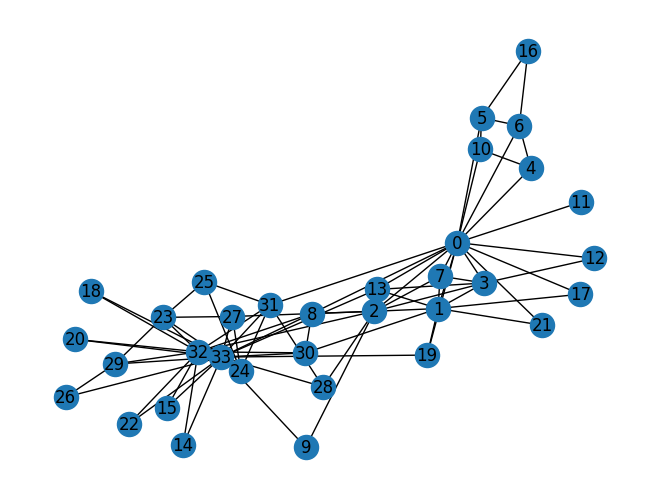

In [4]:
G = nx.karate_club_graph()
nx.draw(G, with_labels=True)
plt.show()

# ساخت یک گراف نمونه
G = dgl.from_networkx(G)

# ویژگی‌های اولیه گره‌ها (اختیاری)
G.ndata['feat'] = torch.eye(G.number_of_nodes())

class GNN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GNN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_feats)
        self.conv2 = GraphConv(hidden_feats, out_feats)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

class LinkPredictor(nn.Module):
    def __init__(self, in_feats):
        super(LinkPredictor, self).__init__()
        self.gnn = GNN(in_feats, 16, 8)
        self.predictor = nn.Sequential(
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, g, u, v):
        h = self.gnn(g, g.ndata['feat'])
        score = self.predictor(torch.cat([h[u], h[v]], dim=1))
        return score


**Train And Test Model**

In [5]:
# پارامترها
in_feats = G.ndata['feat'].shape[1]
model = LinkPredictor(in_feats)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

# داده‌های آموزشی (نمونه)
u = torch.tensor([0, 1, 2, 3])
v = torch.tensor([1, 2, 3, 4])
labels = torch.tensor([1, 1, 0, 0], dtype=torch.float32)

# آموزش مدل
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    predictions = model(G, u, v).squeeze()
    loss = loss_fn(predictions, labels)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.item():.4f}')

print("Training completed.")

# پیش‌بینی پیوند
def predict_link(model, g, u, v):
    model.eval()
    with torch.no_grad():
        score = model(g, u, v)
        return score

# نمونه‌ای از پیش‌بینی پیوند
u_test = torch.tensor([0, 5])
v_test = torch.tensor([1, 6])
predictions = predict_link(model, G, u_test, v_test).squeeze()

for i in range(len(u_test)):
    print(f'Prediction for link ({u_test[i].item()}, {v_test[i].item()}): {predictions[i].item():.4f}')

/usr/local/lib/python3.11/dist-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch 10, Loss: 0.6829
Epoch 20, Loss: 0.6179
Epoch 30, Loss: 0.4340
Epoch 40, Loss: 0.3022
Epoch 50, Loss: 0.2663
Epoch 60, Loss: 0.2395
Epoch 70, Loss: 0.2168
Epoch 80, Loss: 0.1960
Epoch 90, Loss: 0.1055
Epoch 100, Loss: 0.0050
Training completed.
Prediction for link (0, 1): 0.9977
Prediction for link (5, 6): 0.8900
